<a href="https://colab.research.google.com/github/Dhanushsirigineedi/DL-Assignment-1/blob/main/DL_Assignment_1_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import wandb
import socket
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn

# Set socket timeout to avoid connection issues
socket.setdefaulttimeout(30)

In [ ]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
train_images, validation_images,train_labels, validation_labels  = train_test_split(X_train,Y_train,test_size = 0.1)

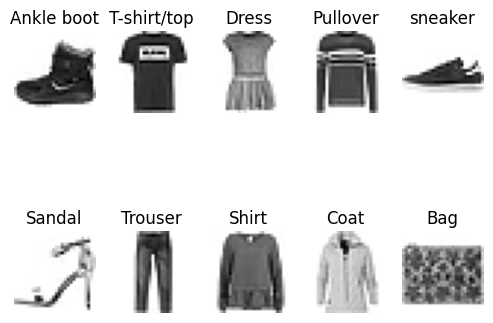

In [ ]:
(train_images_to_plot, train_labels_to_plot), (test_images_to_plot, test_labels_to_plot) = fashion_mnist.load_data()
mySet = np.unique(train_labels_to_plot)
myData  = []
count = 10
for train_image,train_label in zip(train_images_to_plot,train_labels_to_plot):
  if(train_label in mySet ):
    index = np.where(mySet == train_label)
    myData.append(train_image)
    mySet = np.delete(mySet,index)
    count-=1
  if(count == 0):
    break
names =['Ankle boot','T-shirt/top','Dress','Pullover','sneaker','Sandal','Trouser','Shirt','Coat','Bag']
fig, axes = plt.subplots(2, 5, figsize=(5, 5))
for i, ax in enumerate(axes.flat):
    ax.set_title(names[i])
    ax.imshow(myData[i], cmap=plt.cm.binary)
    ax.axis('off')
plt.tight_layout()
#wandb.log({'plt':plt})
plt.show()

In [ ]:
def softmax_func(z):
  eps = 1e-6
  #return (np.exp(z-max(z)) / (sum(np.exp(z-max(z))) + eps))
  return np.exp(z - np.max(z, axis=0, keepdims=True)) / (np.sum(np.exp(z - np.max(z, axis=0, keepdims=True)), axis=0, keepdims=True) + eps)

In [ ]:
def sigmoid_func(z):
  #z = np.clip(z, -500, 500)
  #return 1/(1+np.exp(-z))
  return 1 / (1 + np.exp(-np.clip(z, -50, 50)))

In [ ]:
def sigmoid__func_derivative(z):
  return sigmoid_func(z) * (1 - sigmoid_func(z))

In [ ]:
def tanh_func(z):
  clipped_z = np.clip(z, -50, 50)
  return np.tanh(clipped_z)

In [ ]:
def tanh_func_derivative(z):
  return 1-np.tanh(z)**2

In [ ]:
def identity_func(z):
  return z

In [ ]:
def identity_func_derivative(z):
  res = np.ones(z.shape)
  return res

In [ ]:
def relu_func(z):
  return np.maximum(0,z)

In [ ]:
#def relu_func_derivative(z):
#  return np.where(z>0,1,0)
def relu_func_derivative(z, alpha=0.01):
    return np.where(z > 0, 1, alpha)

In [ ]:
import copy

In [ ]:
def forwardPropogation(no_of_layers,training_input_data,W_matrix,b_matrix,activationFunction):
  a_matrix = [0 for i in range(no_of_layers+1)]
  h_matrix = [0 for i in range(no_of_layers+1)]
  for i in range(0,no_of_layers):
    if(i<1):
      a_matrix[i] = np.matmul(W_matrix[i], training_input_data) + b_matrix[i]
    else:
      a_matrix[i] = np.matmul(W_matrix[i],h_matrix[i-1]) + b_matrix[i]

    if(activationFunction == 'sigmoid'):
      h_matrix[i] = sigmoid_func(a_matrix[i])
    elif(activationFunction == 'tanh'):
      h_matrix[i] = tanh_func(a_matrix[i])
    elif(activationFunction == 'relu'):
      h_matrix[i] = relu_func(a_matrix[i])
    else:
      h_matrix[i] = identity_func(a_matrix[i])

  a_matrix[no_of_layers] =  np.matmul(W_matrix[no_of_layers],h_matrix[no_of_layers-1]) + b_matrix[no_of_layers]
  h_matrix[no_of_layers] = np.copy(softmax_func(a_matrix[no_of_layers]))
  return a_matrix,h_matrix

In [ ]:
def backwardPropogation(no_of_layers,training_input_data,W_matrix,a_matrix,h_matrix,target_class,activationFunction,lossFunction):
  e_of_l = np.zeros((10,1))
  e_of_l[target_class] = 1
  d_of_W = [0 for i in range(no_of_layers+1)]
  d_of_b = [0 for i in range(no_of_layers+1)]

  if(lossFunction=='entropy'):
    d_of_a = -(e_of_l - h_matrix[no_of_layers])
  else :
    d_of_a = (h_matrix[no_of_layers])*(h_matrix[no_of_layers]-e_of_l)*(1-h_matrix[no_of_layers])

  layers = len(W_matrix)-1
  while(layers>0):
    d_of_W[layers] = np.matmul(d_of_a,(h_matrix[layers-1].T))
    d_of_b[layers] = np.copy(d_of_a)
    d_of_h_layers_minus_1 = np.matmul((W_matrix[layers].T),d_of_a)

    if(activationFunction == 'sigmoid'):
      d_of_a = np.multiply(d_of_h_layers_minus_1,sigmoid__func_derivative(a_matrix[layers-1])) #for next iteration
    elif(activationFunction == 'tanh'):
      d_of_a = np.multiply(d_of_h_layers_minus_1,tanh_func_derivative(a_matrix[layers-1]))
    elif(activationFunction == 'relu'):
      d_of_a = np.multiply(d_of_h_layers_minus_1,relu_func_derivative(a_matrix[layers-1]))
    else:
      d_of_a = np.multiply(d_of_h_layers_minus_1,identity_func_derivative(a_matrix[layers-1]))
    layers-=1

  d_of_W[0] = np.matmul(d_of_a,training_input_data.T)
  d_of_b[0] = np.copy(d_of_a)
  return d_of_W,d_of_b

In [ ]:
def parameter_intializer(no_of_layers,neurons,parameter_initialize_type):
  W_matrix = []
  b_matrix = []
  nodes_in_prev_layer = 784

  for i in range(0,no_of_layers):
    W_matrix.append(np.random.randn(neurons,nodes_in_prev_layer))
    if(parameter_initialize_type == 'random'):
      b_matrix.append(np.random.randn(neurons, 1))
    else:
      b_matrix.append(np.zeros((neurons, 1)))
    nodes_in_prev_layer = neurons

  W_matrix.append(np.random.randn(10,nodes_in_prev_layer))
  if(parameter_initialize_type == 'random'):
    b_matrix.append(np.random.randn(10,1))
  else:
    b_matrix.append(np.zeros((10, 1)))

  return W_matrix,b_matrix

In [ ]:
def training_Accuracy_Calculator(no_of_layers,training_input_data,training_label,W_matrix,b_matrix,activationFunction,lossFunction):
  a_matrix,h_matrix = forwardPropogation(no_of_layers,training_input_data,W_matrix,b_matrix,activationFunction)
  output = np.copy(h_matrix[no_of_layers])
  maxi = -1
  max_label = -1
  for i in range(0,10):
    if(output[i] > maxi ):
      maxi = output[i]
      max_label = i

  if(lossFunction == 'entropy'):
    return max_label,-np.log(output[training_label]+(1e-5))
  else:
    e_of_l = np.zeros((10,1))
    e_of_l[training_label] = 1
    return max_label, np.sum((h_matrix[no_of_layers]-e_of_l)**2)

In [ ]:
def validation_Accuracy_Calculator(no_of_layers,validation_input_data,validation_label,W_matrix,b_matrix,activationFunction,lossFunction):
  a_matrix,h_matrix = forwardPropogation(no_of_layers,validation_input_data,W_matrix,b_matrix,activationFunction)
  output = np.copy(h_matrix[no_of_layers])
  maxi = -1
  max_label = -1
  for i in range(0,10):
    if(output[i] > maxi ):
      maxi = output[i]
      max_label = i

  if(lossFunction == 'entropy'):
    return max_label,-np.log(output[validation_label]+(1e-5))
  else:
    e_of_l = np.zeros((10,1))
    e_of_l[validation_label] = 1
    return max_label, np.sum((h_matrix[no_of_layers]-e_of_l)**2)

In [ ]:
def SchotasticGD(no_of_layers,neurons,maxiterations,learningRate,weightDecay,parameter_initialize_type,batchSize,activationFunction,lossFunction):
  W_matrix,b_matrix = parameter_intializer(no_of_layers,neurons,parameter_initialize_type)

  for iteration in range(0,maxiterations):
    for training_image,training_label in zip(train_images,train_labels):
      training_image = training_image.reshape(784,1)/255.0
      a_matrix,h_matrix = forwardPropogation(no_of_layers,training_image,W_matrix,b_matrix,activationFunction)
      d_of_W,d_of_b = backwardPropogation(no_of_layers,training_image,W_matrix,a_matrix,h_matrix,training_label,activationFunction,lossFunction)
      for i in range(0,no_of_layers+1):
        W_matrix[i] = W_matrix[i] - (learningRate) * ( d_of_W[i]) - (weightDecay * W_matrix[i])
        b_matrix[i] = b_matrix[i] - (learningRate)* ( d_of_b[i])

    wandb.log({'epoch':iteration})

    training_accuracy_count=0
    total_training_loss = 0
    for training_image,training_label in zip(train_images,train_labels):
      training_image = training_image.reshape(784,1)/255.0
      label,accuracy_loss = training_Accuracy_Calculator(no_of_layers,training_image,training_label,W_matrix,b_matrix,activationFunction,lossFunction)
      total_training_loss += accuracy_loss
      if( label == training_label):
          training_accuracy_count+=1
    wandb.log({'training_accuracy_count':training_accuracy_count/540})
    wandb.log({'training_accuracy_loss':total_training_loss/ 54000})
    print("Iteration : ",iteration)
    print("training_accuracy_count :",training_accuracy_count/540,"training_accuracy_loss :",total_training_loss/54000)

    validation_accuracy_count = 0
    total_validation_loss = 0
    for validation_image,validation_label in zip(validation_images,validation_labels):
      validation_image = validation_image.reshape(784,1)/255.0
      label,accuracy_loss = validation_Accuracy_Calculator(no_of_layers,validation_image,validation_label,W_matrix,b_matrix,activationFunction,lossFunction)
      total_validation_loss += accuracy_loss
      if( label == validation_label):
        validation_accuracy_count +=1
    wandb.log({'validation_accuracy_count':validation_accuracy_count/60})
    wandb.log({'validation_accuracy_loss':total_validation_loss/6000})
    print("validation_accuracy_count :",validation_accuracy_count/60,"validation_accuracy :",total_validation_loss/6000)
  return training_accuracy_count

In [ ]:
def MomentumGD(no_of_layers,neurons,maxiterations,weightDecay,learningRate,batchSize,parameter_initialize_type,activationFunction,lossFunction):
  W_matrix,b_matrix = parameter_intializer(no_of_layers,neurons,parameter_initialize_type)
  previous_W_of_u = [0 for i in range(0,no_of_layers+1)]
  previous_b_of_u = [0 for i in range(0,no_of_layers+1)]
  eta = learningRate
  beta = 0.9

  for iteration in range(0,maxiterations):
    temp_iterations = 0
    total_d_of_W = [0 for i in range(0,no_of_layers+1)]
    total_d_of_b = [0 for i in range(0,no_of_layers+1)]

    for training_image,training_label in zip(train_images,train_labels):
      training_image = training_image.reshape(784,1)/255.0
      a_matrix,h_matrix = forwardPropogation(no_of_layers,training_image,W_matrix,b_matrix,activationFunction)
      d_of_W,d_of_b = backwardPropogation(no_of_layers,training_image,W_matrix,a_matrix,h_matrix,training_label,activationFunction,lossFunction)
      for i in range(0,no_of_layers+1):
        total_d_of_W[i] += d_of_W[i]
        total_d_of_b[i] += d_of_b[i]

      temp_iterations+=1

      if(temp_iterations % batchSize == 0):
        for i in range(0,no_of_layers+1):
          curr_W_of_u =  (beta * previous_W_of_u[i])+total_d_of_W[i]
          curr_b_of_u =  (beta * previous_b_of_u[i])+total_d_of_b[i]
          W_matrix[i] = (W_matrix[i] -  (eta * curr_W_of_u) - (weightDecay * W_matrix[i]))
          b_matrix[i] = (b_matrix[i] -  (eta * curr_b_of_u))

          previous_W_of_u[i] = np.copy(curr_W_of_u)
          previous_b_of_u[i] = np.copy(curr_b_of_u)

          for row in total_d_of_W:
            row[:] = 0
          for row in total_d_of_b:
            row[:] = 0

    wandb.log({'epoch':iteration})

    training_accuracy_count=0
    total_training_loss = 0
    for training_image,training_label in zip(train_images,train_labels):
      training_image = training_image.reshape(784,1)/255.0
      label,accuracy_loss = training_Accuracy_Calculator(no_of_layers,training_image,training_label,W_matrix,b_matrix,activationFunction,lossFunction)
      total_training_loss += accuracy_loss
      if( label == training_label):
          training_accuracy_count+=1
    wandb.log({'training_accuracy_count':training_accuracy_count/540})
    wandb.log({'training_accuracy_loss':total_training_loss/ 54000})
    print("Iteration : ",iteration)
    print("training_accuracy_count :",training_accuracy_count/540,"training_accuracy_loss :",total_training_loss/54000)

    validation_accuracy_count = 0
    total_validation_loss = 0
    for validation_image,validation_label in zip(validation_images,validation_labels):
      validation_image = validation_image.reshape(784,1)/255.0
      label,accuracy_loss = validation_Accuracy_Calculator(no_of_layers,validation_image,validation_label,W_matrix,b_matrix,activationFunction,lossFunction)
      total_validation_loss += accuracy_loss
      if( label == validation_label):
        validation_accuracy_count +=1
    wandb.log({'validation_accuracy_count':validation_accuracy_count/60})
    wandb.log({'validation_accuracy_loss':total_validation_loss/6000})
    print("validation_accuracy_count :",validation_accuracy_count/60,"validation_accuracy_loss :",total_validation_loss/6000)
  return training_accuracy_count

In [ ]:
def NesterovGD(no_of_layers,neurons,maxiterations,weightDecay,learningRate,batchSize,parameter_initialize_type,activationFunction,lossFunction):
  W_matrix,b_matrix = parameter_intializer(no_of_layers,neurons,parameter_initialize_type)
  previous_W_of_u = [0 for i in range(0,no_of_layers+1)]
  previous_b_of_u = [0 for i in range(0,no_of_layers+1)]
  eta = learningRate
  beta = 0.9

  for iteration in range(0,maxiterations):
    temp_iterations = 0
    total_d_of_W = [0 for i in range(0,no_of_layers+1)]
    total_d_of_b = [0 for i in range(0,no_of_layers+1)]

    for i in range(0,no_of_layers+1):
      W_matrix[i] = W_matrix[i] - (beta * previous_W_of_u[i])
      b_matrix[i] = b_matrix[i] - (beta * previous_b_of_u[i])

    for training_image,training_label in zip(train_images,train_labels):
      training_image = training_image.reshape(784,1)/255.0
      a_matrix,h_matrix = forwardPropogation(no_of_layers,training_image,W_matrix,b_matrix,activationFunction)
      d_of_W,d_of_b = backwardPropogation(no_of_layers,training_image,W_matrix,a_matrix,h_matrix,training_label,activationFunction,lossFunction)
      for i in range(0,no_of_layers+1):
        total_d_of_W[i] += d_of_W[i]
        total_d_of_b[i] += d_of_b[i]

      temp_iterations+=1

      if(temp_iterations % batchSize == 0):
        for i in range(0,no_of_layers+1):
          W_matrix[i] = W_matrix[i]- eta * total_d_of_W[i] - (weightDecay * W_matrix[i])
          b_matrix[i] = b_matrix[i] - eta * total_d_of_b[i]
          previous_W_of_u[i] =   beta * previous_W_of_u[i] + eta * total_d_of_W[i]
          previous_b_of_u[i] =   beta * previous_b_of_u[i] + eta * total_d_of_b[i]
        for row in total_d_of_W:
            row[:] = 0
        for row in total_d_of_b:
            row[:] = 0

    wandb.log({'epoch':iteration})

    training_accuracy_count=0
    total_training_loss = 0
    for training_image,training_label in zip(train_images,train_labels):
      training_image = training_image.reshape(784,1)/255.0
      label,accuracy_loss = training_Accuracy_Calculator(no_of_layers,training_image,training_label,W_matrix,b_matrix,activationFunction,lossFunction)
      total_training_loss += accuracy_loss
      if( label == training_label):
          training_accuracy_count+=1
    wandb.log({'training_accuracy_count':training_accuracy_count/540})
    wandb.log({'training_accuracy_loss':total_training_loss/ 54000})
    print("Iteration : ",iteration)
    print("training_accuracy_count :",training_accuracy_count/540,"training_accuracy_loss :",total_training_loss/54000)

    validation_accuracy_count = 0
    total_validation_loss = 0
    for validation_image,validation_label in zip(validation_images,validation_labels):
      validation_image = validation_image.reshape(784,1)/255.0
      label,accuracy_loss = validation_Accuracy_Calculator(no_of_layers,validation_image,validation_label,W_matrix,b_matrix,activationFunction,lossFunction)
      total_validation_loss += accuracy_loss
      if( label == validation_label):
        validation_accuracy_count +=1
    wandb.log({'validation_accuracy_count':validation_accuracy_count/60})
    wandb.log({'validation_accuracy_loss':total_validation_loss/6000})
    print("validation_accuracy_count :",validation_accuracy_count/60,"validation_accuracy_loss :",total_validation_loss/6000)
  return training_accuracy_count

In [ ]:
def rmsProp(no_of_layers,neurons,maxiterations,weightDecay,learningRate,batchSize,parameter_initialize_type,activationFunction,lossFunction):
  W_matrix,b_matrix = parameter_intializer(no_of_layers,neurons,parameter_initialize_type)
  W_of_v = [0 for i in range(0,no_of_layers+1)]
  b_of_v = [0 for i in range(0,no_of_layers+1)]
  eta = learningRate
  beta = 0.5
  eps = 1e-4

  for iteration in range(0,maxiterations):
    temp_iterations = 0
    total_d_of_W = [0 for i in range(0,no_of_layers+1)]
    total_d_of_b = [0 for i in range(0,no_of_layers+1)]

    for training_image,training_label in zip(train_images,train_labels):
      training_image = training_image.reshape(784,1)/255.0
      a_matrix,h_matrix = forwardPropogation(no_of_layers,training_image,W_matrix,b_matrix,activationFunction)
      d_of_W,d_of_b = backwardPropogation(no_of_layers,training_image,W_matrix,a_matrix,h_matrix,training_label,activationFunction,lossFunction)
      for i in range(0,no_of_layers+1):
        total_d_of_W[i] += d_of_W[i]
        total_d_of_b[i] += d_of_b[i]

      temp_iterations+=1

      if(temp_iterations % batchSize == 0):
        for i in range(0,no_of_layers+1):
          W_of_v[i] =  (1-beta)* (total_d_of_W[i] ** 2) + beta * W_of_v[i]
          b_of_v[i] =  (1-beta) * (total_d_of_b[i] ** 2) + beta * b_of_v[i]
          W_matrix[i] = W_matrix[i] - eta * total_d_of_W[i]/(np.sqrt(W_of_v[i])+eps) - (weightDecay * W_matrix[i])
          b_matrix[i] = b_matrix[i] - eta * total_d_of_b[i]/(np.sqrt(b_of_v[i])+eps)
          for row in total_d_of_W:
            row[:] = 0
          for row in total_d_of_b:
            row[:] = 0

    wandb.log({'epoch':iteration})

    training_accuracy_count=0
    total_training_loss = 0
    for training_image,training_label in zip(train_images,train_labels):
      training_image = training_image.reshape(784,1)/255.0
      label,accuracy_loss = training_Accuracy_Calculator(no_of_layers,training_image,training_label,W_matrix,b_matrix,activationFunction,lossFunction)
      total_training_loss += accuracy_loss
      if( label == training_label):
          training_accuracy_count+=1
    wandb.log({'training_accuracy_count':training_accuracy_count/540})
    wandb.log({'training_accuracy_loss':total_training_loss/ 54000})
    print("Iteration : ",iteration)
    print("training_accuracy_count :",training_accuracy_count/540,"training_accuracy_loss :",total_training_loss/54000)

    validation_accuracy_count = 0
    total_validation_loss = 0
    for validation_image,validation_label in zip(validation_images,validation_labels):
      validation_image = validation_image.reshape(784,1)/255.0
      label,accuracy_loss = validation_Accuracy_Calculator(no_of_layers,validation_image,validation_label,W_matrix,b_matrix,activationFunction,lossFunction)
      total_validation_loss += accuracy_loss
      if( label == validation_label):
        validation_accuracy_count +=1
    wandb.log({'validation_accuracy_count':validation_accuracy_count/60})
    wandb.log({'validation_accuracy_loss':total_validation_loss/6000})
    print("validation_accuracy_count :",validation_accuracy_count/60,"validation_accuracy_loss :",total_validation_loss/6000)
  return training_accuracy_count

In [ ]:
def adam(no_of_layers,neurons,maxiterations,weightDecay,learningRate,batchSize,parameter_initialize_type,activationFunction,lossFunction):
  W_matrix,b_matrix = parameter_intializer(no_of_layers,neurons,parameter_initialize_type)
  eta = learningRate
  beta1 = 0.9
  beta2 = 0.999
  eps = 1e-10

  W_of_m = [0 for i in range(0,no_of_layers+1)]
  b_of_m = [0 for i in range(0,no_of_layers+1)]
  W_of_v = [0 for i in range(0,no_of_layers+1)]
  b_of_v = [0 for i in range(0,no_of_layers+1)]

  for iteration in range(0,maxiterations):
    temp_iterations = 0
    total_d_of_W = [0 for i in range(0,no_of_layers+1)]
    total_d_of_b = [0 for i in range(0,no_of_layers+1)]

    for training_image,training_label in zip(train_images,train_labels):
      training_image = training_image.reshape(784,1)/255.0
      a_matrix,h_matrix = forwardPropogation(no_of_layers,training_image,W_matrix,b_matrix,activationFunction)
      d_of_W,d_of_b = backwardPropogation(no_of_layers,training_image,W_matrix,a_matrix,h_matrix,training_label,activationFunction,lossFunction)
      for i in range(0,no_of_layers+1):
        total_d_of_W[i] += d_of_W[i]
        total_d_of_b[i] += d_of_b[i]

      temp_iterations+=1

      if(temp_iterations % batchSize == 0):
        for i in range(0,no_of_layers+1):
          W_of_m[i] = (1-beta1)*total_d_of_W[i] + beta1 * W_of_m[i]
          b_of_m[i] = (1-beta1)*total_d_of_b[i] + beta1 * b_of_m[i]
          W_of_v[i] = (1-beta2) * total_d_of_W[i]**2 + beta2 * W_of_v[i]
          b_of_v[i] = (1-beta2) * total_d_of_b[i]**2 + beta2 * b_of_v[i]

          W_of_m_cap = W_of_m[i] / (1-np.power(beta1,iteration+1))
          b_of_m_cap = b_of_m[i] / (1-np.power(beta1,iteration+1))
          W_of_v_cap = W_of_v[i] / (1-np.power(beta2,iteration+1))
          b_of_v_cap = b_of_v[i] / (1-np.power(beta2,iteration+1))

          W_matrix[i] = W_matrix[i] - eta * (W_of_m_cap / (np.sqrt(W_of_v_cap)+eps)) - (weightDecay * W_matrix[i])
          b_matrix[i] = b_matrix[i] - eta* b_of_m_cap/ (np.sqrt(b_of_v_cap)+eps)

        for row in total_d_of_W:
            row[:] = 0
        for row in total_d_of_b:
            row[:] = 0

    wandb.log({'epoch':iteration})

    training_accuracy_count=0
    total_training_loss = 0
    for training_image,training_label in zip(train_images,train_labels):
      training_image = training_image.reshape(784,1)/255.0
      label,accuracy_loss = training_Accuracy_Calculator(no_of_layers,training_image,training_label,W_matrix,b_matrix,activationFunction,lossFunction)
      total_training_loss += accuracy_loss
      if( label == training_label):
          training_accuracy_count+=1
    wandb.log({'training_accuracy_count':training_accuracy_count/540})
    wandb.log({'training_accuracy_loss':total_training_loss/ 54000})
    print("Iteration : ",iteration)
    print("training_accuracy_count :",training_accuracy_count/540,"training_accuracy_loss :",total_training_loss/54000)

    validation_accuracy_count = 0
    total_validation_loss = 0
    for validation_image,validation_label in zip(validation_images,validation_labels):
      validation_image = validation_image.reshape(784,1)/255.0
      label,accuracy_loss = validation_Accuracy_Calculator(no_of_layers,validation_image,validation_label,W_matrix,b_matrix,activationFunction,lossFunction)
      total_validation_loss += accuracy_loss
      if( label == validation_label):
        validation_accuracy_count +=1
    wandb.log({'validation_accuracy_count':validation_accuracy_count/60})
    wandb.log({'validation_accuracy_loss':total_validation_loss/6000})
    print("validation_accuracy_count :",validation_accuracy_count/60,"validation_accuracy_loss :",total_validation_loss/6000)
  return training_accuracy_count

In [ ]:
def nadam(no_of_layers,neurons,maxiterations,weightDecay,learningRate,batchSize,parameter_initialize_type,activationFunction,lossFunction):
  W_matrix,b_matrix = parameter_intializer(no_of_layers,neurons,parameter_initialize_type)
  eta = learningRate
  beta1 = 0.9
  beta2 = 0.999
  eps = 1e-10

  W_of_m = [0 for i in range(0,no_of_layers+1)]
  b_of_m = [0 for i in range(0,no_of_layers+1)]
  W_of_v = [0 for i in range(0,no_of_layers+1)]
  b_of_v = [0 for i in range(0,no_of_layers+1)]

  for iteration in range(0,maxiterations):
    temp_iterations = 0
    total_d_of_W = [0 for i in range(0,no_of_layers+1)]
    total_d_of_b = [0 for i in range(0,no_of_layers+1)]

    for training_image,training_label in zip(train_images,train_labels):
      training_image = training_image.reshape(784,1)/255.0
      a_matrix,h_matrix = forwardPropogation(no_of_layers,training_image,W_matrix,b_matrix,activationFunction)
      d_of_W,d_of_b = backwardPropogation(no_of_layers,training_image,W_matrix,a_matrix,h_matrix,training_label,activationFunction,lossFunction)
      for i in range(0,no_of_layers+1):
        total_d_of_W[i] += d_of_W[i]
        total_d_of_b[i] += d_of_b[i]

      temp_iterations+=1

      if(temp_iterations % batchSize == 0):
        for i in range(0,no_of_layers+1):
          W_of_m[i] = (1-beta1)*total_d_of_W[i] + beta1 * W_of_m[i]
          b_of_m[i] = (1-beta1)*total_d_of_b[i] + beta1 * b_of_m[i]
          W_of_v[i] = (1-beta2) * total_d_of_W[i]**2 + beta2 * W_of_v[i]
          b_of_v[i] = (1-beta2) * total_d_of_b[i]**2 + beta2 * b_of_v[i]

          W_of_m_cap = W_of_m[i] / (1-np.power(beta1,iteration+1))
          b_of_m_cap = b_of_m[i] / (1-np.power(beta1,iteration+1))
          W_of_v_cap = W_of_v[i] / (1-np.power(beta2,iteration+1))
          b_of_v_cap = b_of_v[i] / (1-np.power(beta2,iteration+1))

          W_matrix[i] = W_matrix[i] - (eta / (np.sqrt(W_of_v_cap+eps)))*(beta1 * W_of_m_cap + (1-beta1)*total_d_of_W[i]/(1-beta1**(iteration+1))) - (weightDecay * W_matrix[i])
          b_matrix[i] = b_matrix[i] - (eta / (np.sqrt(b_of_v_cap+eps)))*(beta1 * b_of_m_cap + (1-beta1)*total_d_of_b[i]/(1-beta1**(iteration+1)))

        for row in total_d_of_W:
            row[:] = 0
        for row in total_d_of_b:
            row[:] = 0

    wandb.log({'epoch':iteration})

    training_accuracy_count=0
    total_training_loss = 0
    for training_image,training_label in zip(train_images,train_labels):
      training_image = training_image.reshape(784,1)/255.0
      label,accuracy_loss = training_Accuracy_Calculator(no_of_layers,training_image,training_label,W_matrix,b_matrix,activationFunction,lossFunction)
      total_training_loss += accuracy_loss
      if( label == training_label):
          training_accuracy_count+=1
    wandb.log({'training_accuracy_count':training_accuracy_count/540})
    wandb.log({'training_accuracy_loss':total_training_loss/ 54000})
    print("Iteration : ",iteration)
    print("training_accuracy_count :",training_accuracy_count/540,"training_accuracy_loss :",total_training_loss/54000)

    validation_accuracy_count = 0
    total_validation_loss = 0
    for validation_image,validation_label in zip(validation_images,validation_labels):
      validation_image = validation_image.reshape(784,1)/255.0
      label,accuracy_loss = validation_Accuracy_Calculator(no_of_layers,validation_image,validation_label,W_matrix,b_matrix,activationFunction,lossFunction)
      total_validation_loss += accuracy_loss
      if( label == validation_label):
        validation_accuracy_count +=1
    wandb.log({'validation_accuracy_count':validation_accuracy_count/60})
    wandb.log({'validation_accuracy_loss':total_validation_loss/6000})
    print("validation_accuracy_count :",validation_accuracy_count/60,"validation_accuracy_loss :",total_validation_loss/6000)
  return training_accuracy_count

In [ ]:
def train_the_model(X_train,Y_train,no_of_hiddenlayers,no_of_neurons,no_of_input_nodes,no_of_output_nodes,W_matrix,b_matrix,
                    a_matrix,h_matrix,learningRate,no_of_epochs,batch_size,no_of_training_samples,optimizer,activationFunction,lossFunction,initializer_type,Weight_decay):
  #parameter_intializer(no_of_hiddenlayers,no_of_neurons,initializer_type,W_matrix,b_matrix)
  if optimizer == "schotastic":
    accuracy=SchotasticGD(no_of_hiddenlayers,no_of_neurons,no_of_epochs,Weight_decay,learningRate,batch_size,initializer_type,activationFunction,lossFunction)
  elif optimizer == "momentum":
    accuracy=MomentumGD(no_of_hiddenlayers,no_of_neurons,no_of_epochs,Weight_decay,learningRate,batch_size,initializer_type,activationFunction,lossFunction)
  elif optimizer == "nesterov":
    accuracy=NesterovGD(no_of_hiddenlayers,no_of_neurons,no_of_epochs,Weight_decay,learningRate,batch_size,initializer_type,activationFunction,lossFunction)
  elif optimizer == "rmsprop":
    accuracy=rmsProp(no_of_hiddenlayers,no_of_neurons,no_of_epochs,Weight_decay,learningRate,batch_size,initializer_type,activationFunction,lossFunction)
  elif optimizer == "adam":
    accuracy=adam(no_of_hiddenlayers,no_of_neurons,no_of_epochs,Weight_decay,learningRate,batch_size,initializer_type,activationFunction,lossFunction)
  elif optimizer == "nadam":
    accuracy=nadam(no_of_hiddenlayers,no_of_neurons,no_of_epochs,Weight_decay,learningRate,batch_size,initializer_type,activationFunction,lossFunction)

In [ ]:
# Sweep config for wandb plotting
sweep_config = {
    'name'  : "Dhanush",
    'method': 'bayes',
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'
    },
    'parameters': {
        'no_of_hiddenlayers': {
            'values': [3, 4, 5]
        },
        'no_of_epochs': {
            'values': [5, 10]
        },
        'no_of_neurons': {
            'values': [32, 64, 128]
        },
        'learning_rate': {
            'values': [1e-3, 1e-4]
        },
        'initializer_type': {
            'values': ["random", "xavier"]
        },
        'batch_size': {
            'values': [16, 32, 64]
        },
        'optmizer': {
            'values': ["schotastic", "momentum", "nesterov", "rmsprop", "adam", "nadam"]
        },
        'activation_function': {
            'values': ["sigmoid","tanh",  "relu"]
        },
        'weight_decay': {
            'values': [0, 0.0005, 0.5]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="DA6401_Assignment_1")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: 5st70nqt
Sweep URL: https://wandb.ai/dhanushsirigineedi-iitm-ac-in/DA6401_Assignment_1/sweeps/5st70nqt


In [ ]:
# Initializing and setting training size
no_of_classes = 10
input_size = 784
no_of_training_samples = 54000

# Initialize parameter dictionaries
loss_function = "entropy"
W_matrix = {}
b_matrix = {}
h_matrix = {}
a_matrix = {}

def run_experiment():
    run = wandb.init(config=sweep_config)
    cfg = run.config

    run.name = "No_of_epochs : {} No_of_hidden_layers : {} No_of_neurons : {} Learning_rate : {} Optimizer : {} Batch_size {} Intializer_type : {} Activation_Function : {} Weight_decay : {}".format(
        cfg.no_of_epochs, cfg.no_of_hiddenlayers, cfg.no_of_neurons, cfg.learning_rate, cfg.optmizer, cfg.batch_size, cfg.initializer_type, cfg.activation_function, cfg.weight_decay
    )
    train_the_model(X_train,Y_train,cfg.no_of_hiddenlayers,cfg.no_of_neurons,input_size,no_of_classes,W_matrix,b_matrix,a_matrix,h_matrix,
                cfg.learning_rate,cfg.no_of_epochs,cfg.batch_size,no_of_training_samples,cfg.optmizer,cfg.activation_function,loss_function,cfg.initializer_type,cfg.weight_decay)
wandb.agent(sweep_id, run_experiment,project="DA6401_Assignment_1" ,  count=2)

wandb: Agent Starting Run: dr4vlzmw with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	initializer_type: random
wandb: 	learning_rate: 0.0001
wandb: 	no_of_epochs: 10
wandb: 	no_of_hiddenlayers: 3
wandb: 	no_of_neurons: 128
wandb: 	optmizer: adam
wandb: 	weight_decay: 0.0005
wandb: Currently logged in as: dhanushsirigineedi (dhanushsirigineedi-iitm-ac-in) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Iteration :  0
training_accuracy_count : 56.977777777777774 training_accuracy_loss : [1.88070068]
validation_accuracy_count : 56.6 validation_accuracy_loss : [1.87960975]
Iteration :  1
training_accuracy_count : 9.985185185185186 training_accuracy_loss : [2.31318835]
validation_accuracy_count : 10.133333333333333 validation_accuracy_loss : [2.31350777]
Iteration :  2
training_accuracy_count : 9.985185185185186 training_accuracy_loss : [2.31924627]
validation_accuracy_count : 10.133333333333333 validation_accuracy_loss : [2.31970603]
Iteration :  3
training_accuracy_count : 9.985185185185186 training_accuracy_loss : [2.2952824]
validation_accuracy_count : 10.133333333333333 validation_accuracy_loss : [2.29563595]
Iteration :  4
training_accuracy_count : 18.668518518518518 training_accuracy_loss : [2.28522106]
validation_accuracy_count : 18.7 validation_accuracy_loss : [2.28568058]
Iteration :  5
training_accuracy_count : 18.89814814814815 training_accuracy_loss : [2.28506703]
validation

epoch,▁▂▃▃▄▅▆▆▇█
training_accuracy_count,█▁▁▁▂▂▂▂▂▂
training_accuracy_loss,▁███▇▇▇▇██
validation_accuracy_count,█▁▁▁▂▂▂▂▂▂
validation_accuracy_loss,▁███▇▇▇▇██
epoch,9
training_accuracy_count,17.32963
training_accuracy_loss,2.28829
validation_accuracy_count,17.4
validation_accuracy_loss,2.28881


wandb: Agent Starting Run: zu531la1 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	initializer_type: xavier
wandb: 	learning_rate: 0.001
wandb: 	no_of_epochs: 5
wandb: 	no_of_hiddenlayers: 3
wandb: 	no_of_neurons: 32
wandb: 	optmizer: nesterov
wandb: 	weight_decay: 0


Iteration :  0
training_accuracy_count : 60.45 training_accuracy_loss : [1.08112992]
validation_accuracy_count : 60.43333333333333 validation_accuracy_loss : [1.08320692]
Iteration :  1
training_accuracy_count : 66.53148148148148 training_accuracy_loss : [0.89097745]
validation_accuracy_count : 66.33333333333333 validation_accuracy_loss : [0.89360352]
Iteration :  2
training_accuracy_count : 69.72962962962963 training_accuracy_loss : [0.80399704]
validation_accuracy_count : 69.51666666666667 validation_accuracy_loss : [0.80734396]
Iteration :  3
training_accuracy_count : 71.85740740740741 training_accuracy_loss : [0.75141756]
validation_accuracy_count : 71.43333333333334 validation_accuracy_loss : [0.75485675]
Iteration :  4
training_accuracy_count : 73.47222222222223 training_accuracy_loss : [0.71414834]
validation_accuracy_count : 72.95 validation_accuracy_loss : [0.71787282]


epoch,▁▃▅▆█
training_accuracy_count,▁▄▆▇█
training_accuracy_loss,█▄▃▂▁
validation_accuracy_count,▁▄▆▇█
validation_accuracy_loss,█▄▃▂▁
epoch,4
training_accuracy_count,73.47222
training_accuracy_loss,0.71415
validation_accuracy_count,72.95
validation_accuracy_loss,0.71787
